# **MACS 207-b | Project 1 | Aristide LALOUX & Hugo QUENIAT**

## **Project Summary**

We consider a point process $N$  and a stopping time $\tau$ with distribution function $F$  and density $f$. We know that before $\tau$, $N$ is a Poisson process with intensity  $\lambda_0$ , and after $\tau$, $N$ becomes a Poisson process with intensity  $\lambda_1$.

Let $\mathcal{F}_t = \sigma(N(s), s\leq t)$ be the sigma-algebra that contains the information provided by the trajectory of $N$ up to time $t$.

We introduce $\hat{Z}(t) = P(\tau \leq t | \mathcal{F_t})$ which represents the probability that $\tau$ has occurred before time  $t$ given the trajectory of $N$ up to time $t$.

The objective of the project is to successfully estimate $\tau$ based on a simulation of $N$.



In the exercice 2.5.6, we have shown that :

$$\hat{Z}(t) = \int_0^t h(s)(1-\hat{Z}(s))ds + \int_0^t \frac{(\lambda_1-\lambda_0)\hat{Z}(s^-)(1-\hat{Z}(s^-))}{\hat{\lambda}(s)}(dN(s) + \hat{\lambda}(s)ds)$$

With :

$$\hat{\lambda}(s) = \lambda_0 + (\lambda_1-\lambda_0) \mathbb{I}_{ \{ \tau\leq t \} } $$

$$ h(s) = \frac{f(s)}{1-F(s)}$$

## **Setup the environment, parameters and import useful functions**

In [215]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import signal
from scipy.optimize import minimize_scalar
from scipy.special import gammaln
import time

In [194]:
# Parameters

sigma = 0.1 # 1/mean of the exponential distribution followed by the time tau
lambda0 = 4 # intensity of the first Poisson process
lambda1 = 8 # intensity of the second Poisson process
end = 20 # end of the time interval [0, end]

## **Question 1 - Theory, Dynamic between the jumps & Size of the jumps**

First, we examine the dynamics of $\hat{Z}(t)$ between jumps and the size of the jumps.

Since $N$ is a point process, the integral with respect to $N(s)$ becomes a sum at the discontinuities.

$$\hat{Z}(t) = \int_0^t h(s)(1-\hat{Z}(s))ds + \sum_{T_q\leq t} \frac{(\lambda_1-\lambda_0)\hat{Z}(T_q^-)(1-\hat{Z}(T_q^-))}{\hat{\lambda}(T_q^-)} - \int_0^t (\lambda_1-\lambda_0)\hat{Z}(s)(1-\hat{Z}(s)) ds$$



If $T_n$ is the time of the last jump, we obtain the dynamics between jumps:

$$\forall t \in ]T_n, T_{n+1}[$$

$$\hat{Z}(t) - \hat{Z}(T_n) = \int_0^t h(s)(1-\hat{Z}(s))ds + \sum_{T_q\leq t} \frac{(\lambda_1-\lambda_0)\hat{Z}(T_q^-)(1-\hat{Z}(T_q^-))}{\hat{\lambda}(T_q^-)} - \int_0^t (\lambda_1-\lambda_0)\hat{Z}(s)(1-\hat{Z}(s)) ds$$

$$- \int_0^{T_n} h(s)(1-\hat{Z}(s))ds - \sum_{T_q\leq T_n} \frac{(\lambda_1-\lambda_0)\hat{Z}(T_q^-)(1-\hat{Z}(T_q^-))}{\hat{\lambda}(T_q^-)} + \int_0^{T_n} (\lambda_1-\lambda_0)\hat{Z}(s)(1-\hat{Z}(s)) ds$$

Hence : 

$$\hat{Z}(t) - \hat{Z}(T_n) = \int_{T_n}^t h(s)(1-\hat{Z}(s))ds - \int_{T_n}^t (\lambda_1-\lambda_0)\hat{Z}(s)(1-\hat{Z}(s))ds$$

$$ \boxed{ \forall t \in ]T_n, T_{n+1}[ : \hat{Z}(t) - \hat{Z}(T_n) = \int_{T_n}^t (h(s) - (\lambda_1 - \lambda_0)\hat{Z}(s))(1-\hat{Z}(s))ds} $$


In addition, in the expression,

$$\hat{Z}(t) = \int_0^t h(s)(1-\hat{Z}(s))ds + \sum_{T_q\leq t} \frac{(\lambda_1-\lambda_0)\hat{Z}(T_q^-)(1-\hat{Z}(T_q^-))}{\hat{\lambda}(T_q^-)} - \int_0^t (\lambda_1-\lambda_0)\hat{Z}(s)(1-\hat{Z}(s)) ds$$

only the term in the sum can jump. Therefore,

$$\hat{Z}(T_n) - \hat{Z}(T_n^-)  =  \sum_{T_q\leq T_n} \frac{(\lambda_1-\lambda_0)\hat{Z}(T_q^-)(1-\hat{Z}(T_q^-))}{\hat{\lambda}(T_q^-)} - \sum_{T_q\leq T_n^-} \frac{(\lambda_1-\lambda_0)\hat{Z}(T_q^-)(1-\hat{Z}(T_q^-))}{\hat{\lambda}(T_q^-)}$$

i.e., the amplitude of the jump is given by:

$$ \boxed{\hat{Z}(T_n) - \hat{Z}(T_n^-)  =  \frac{(\lambda_1-\lambda_0)\hat{Z}(T_n^-)(1-\hat{Z}(T_n^-))}{\hat{\lambda}(T_n^-)} = \frac{(\lambda_1-\lambda_0)\hat{Z}(T_n^-)(1-\hat{Z}(T_n^-))}{\lambda_0 + (\lambda_1-\lambda_0)\hat{Z}(T_n^-)}} $$

We consider the case where $\tau \sim \mathcal{E} (\sigma)$.

Therefore, $f(s) = \sigma e^{-\sigma s}$ and $F(s) = 1 - e^{-\sigma s}$.

In other words, $h(s) = \frac{f(s)}{1-F(s)} = \sigma$.

## **Question 2 - Simulation of a sample path of** $\mathcal{N}$ **and corresponding** $\hat{Z}$

### **2.1 - Simulation of a sample path of** $\mathcal{N}$

To plot a sample path of $\mathcal{N}$, we use the function `np.random.exponential` to generate the stopping time $\tau$.

Then, we use again the function `np.random.exponential` to generate the inter-arrival times of the Poisson process before $\tau$ and after $\tau$.


In [158]:
# Function to simulate the point process

def simulate_N(lambda0, lambda1, sigma, end, tau=None):
    """
    Simulate the arrival times of events N0 and N1.

    Parameters:
        lambda0 (float): Parameter lambda0 (intensity of the first Poisson process).
        lambda1 (float): Parameter lambda1 (intensity of the second Poisson process).
        sigma (float): Parameter sigma (1/mean of the exponential distribution followed by the time tau).
        end (float): The end time.
        tau (float): Optional value for tau. If None, it will be randomly generated.

    Returns:
        tuple: A tuple containing tau, t_list0, and t_list1.
               - tau (float): The value of tau.
               - t_list0 (list): List of arrival times for N0.
               - t_list1 (list): List of arrival times for N1.
    """
    if tau is None:
        # Randomly generate tau
        tau = 50
        while tau > end/2:  # We want tau to be less than 3/4 of the end time so that we have enough time to simulate N1
            tau = np.random.exponential(scale=1/sigma)

    t_list0 = [0]
    t = 0
    while min(tau, end) > t:
        # Generate chi, which is exponentially distributed with parameter lambda0, the intensity of the first Poisson process. Chi is the time between two consecutive events of N0.
        chi = np.random.exponential(scale=1/lambda0) 
        t = t + chi
        # If t is less than tau and end, then append t to t_list0 : it is an arrival time of N0. Otherwise, stop the loop, we move on to N1.
        if min(tau, end) >= t:
            t_list0.append(t)

    t = tau
    t_list1 = []
    while end > t:
        # Generate chi, which is exponentially distributed with parameter lambda1, the intensity of the first Poisson process. Chi is the time between two consecutive events of N1.
        chi = np.random.exponential(scale=1/lambda1)
        t = t + chi
        # If t is less than end, then append t to t_list1 : it is an arrival time of N1. Otherwise, stop the loop, it is the end of the simulation.
        if end > t:
            t_list1.append(t)

    return tau, t_list0, t_list1



In [111]:
# Function to plot the point process

def graph_N(tau, points0, points1):
    """
    Plot the point process N(t) with two components: N0(t) and N1(t).

    Parameters:
        tau (float): The value of tau.
        points0 (numpy.ndarray): Array of arrival times for N0.
        points1 (numpy.ndarray): Array of arrival times for N1.

    Returns:
        None
    """
    
    # Generate the corresponding y-values for N0 and N1
    y0 = np.arange(len(points0))
    y1 = np.arange(len(points0), len(points0) + len(points1))

    # Add tau to points1 and update y1 accordingly
    points1 = np.concatenate(([tau], points1))
    y1 = np.concatenate(([y0[-1]], y1))

    # Plot N0(t) and N1(t) as step functions
    plt.figure(figsize=(15, 10))
    plt.step(points0, y0, where='post', label=r'$N_0(t)$ avec $t\leq\tau$', color="blue")
    plt.step(points1, y1, where='post', label=r'$N_1(t)$ avec $t\geq\tau$', color="orange")

    # Add vertical lines to indicate tau and join the step functions
    plt.step([points0[-1], tau], [y0[-1], y0[-1]], where='post', color="blue")  # Left connection
    plt.step([tau, points1[0]], [y0[-1], y0[-1]], where='post', color="orange")  # Right connection

    # Add a vertical line at tau
    plt.axvline(x=tau, color='red', linestyle='--', label=r'$\tau$')

    # Add labels, title, and legend
    plt.legend()
    plt.title("Simulation of N")
    plt.xlabel('time')
    plt.ylabel("jumps")
    plt.text(tau, -1, r'$\tau$ = '+ str(round(tau,3)), ha='center', va='top')
    plt.show()

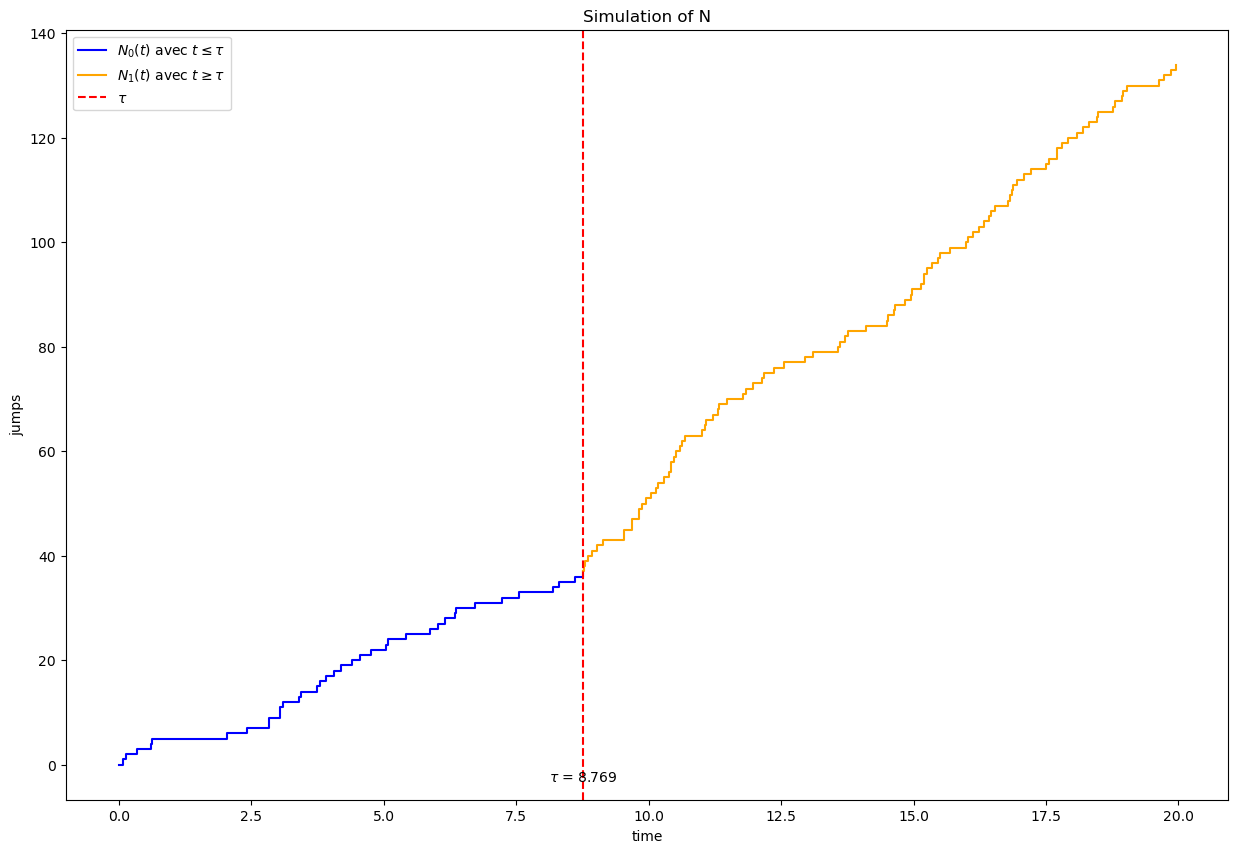

In [159]:
# Compute an example simulation of the Point process and display it

tau, points0, points1 = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)

graph_N (tau, points0, points1)



We can clearly see the difference between the two point processes before and after $\tau$. Indeed, the second one has a higher intensity (twice the first one) and, thus, a higher number of jumps.

### **2.2 -  The corresponding** $\hat{Z}$

To compute and plot $\hat{Z}(t)$, we use the results from question 1:

$$ \boxed{ \hat{Z}(0) = 0}$$

$$ \boxed{\hat{Z}(T_n) = \hat{Z}(T_n^-) + \frac{(\lambda_1-\lambda_0)\hat{Z}(T_n^-)(1-\hat{Z}(T_n^-))}{\lambda_0 + (\lambda_1-\lambda_0)\hat{Z}(T_n^-)}} $$


$$ \forall t \in ]T_n, T_{n+1}[ : \hat{Z}(t) - \hat{Z}(T_n) = \int_{T_n}^t (h(s) - (\lambda_1 - \lambda_0)\hat{Z}(s))(1-\hat{Z}(s))ds $$

$$ \boxed{\forall t \in ]T_n, T_{n+1}[ : \hat{Z}(t)' = (h(s) - (\lambda_1 - \lambda_0)\hat{Z}(t))(1-\hat{Z}(t))} $$

We then solve successively the ODEs verified by $\hat{Z}$.


In [160]:
# Function to compute the function Z(t)

def compute_Z(points0, points1, sigma, lambda0, lambda1, n_step):
    """
    Compute the function Z(t) using numerical integration.

    Parameters:
        points0 (list): List of arrival times for N0.
        points1 (list): List of arrival times for N1.
        sigma (float): Parameter sigma.
        lambda0 (float): Parameter lambda0.
        lambda1 (float): Parameter lambda1.
        n_step (int): Number of steps for numerical integration.

    Returns:
        tuple: A tuple containing Z and t.
               - Z (numpy.ndarray): Array of Z values.
               - t (numpy.ndarray): Array of corresponding time values.
    """
    # Concatenate points0 and points1, meaning getting the whole set of arrival times of the point process N
    points = np.concatenate((points0, points1))
    
    # Initialize Z and t
    t = [0]
    Z = [0]
    
    # The function dZ is the derivative of Z with respect to t, between the jumps.
    dZ = lambda z, t: (sigma - (lambda1 - lambda0) * z) * (1 - z)

    # Compute Z(t) between two jumps
    for i in range(1, len(points)):
        
        # Divide the interval between two points into n_step sub-intervals
        t_portion = np.linspace(points[i-1], points[i], n_step)  

		# Compute Z(t) between the two points, using the derivative dZ
        begin_Z = Z[-1]
        z_portion = odeint(dZ, begin_Z, t_portion).flatten().tolist()
		
		# Concatenate the new values of Z and t
        Z = np.concatenate((Z, z_portion))
        t = np.concatenate((t, t_portion))

		# Add the jump
        t = np.append(t, points[i])
        Z = np.append(Z, Z[-1] + ((lambda1 - lambda0) * Z[-1] * (1 - Z[-1])) / (lambda0 + (lambda1 - lambda0) * Z[-1]))

    return Z, t


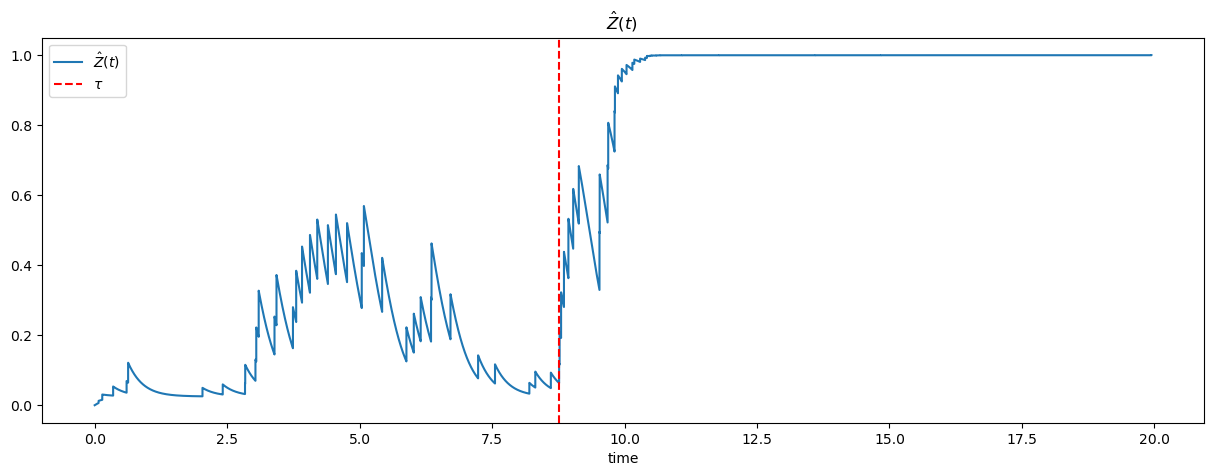

In [161]:
# Compute Z and plot it

# Compute Z(t)
Z, t = compute_Z(points0=points0, points1=points1, sigma=sigma, lambda0=lambda0, lambda1=lambda1, n_step=10000)

# Plot Z(t)
plt.figure(figsize=(15, 5))
plt.plot(t, Z, label=r'$\hat{Z}(t)$')
plt.title(r'$\hat{Z}(t)$ ')
plt.xlabel("time")
plt.axvline(x=tau, color='red', linestyle='--', label=r'$\tau$')
plt.legend()


## **Question 3 - Estimation of** $\tau$

If we suppose that $\hat{Z}(t)$ is a true estimator of $Z(t) = \mathbb{P}(\tau \leq t)$, then we can estimate $\tau$ by $\hat{\tau} = \inf \{ t \geq 0 : \hat{Z}(t) \geq \theta \}$, where $\theta$ is a threshold determined experimentally.

Furthermore, we can also differentiate $\hat{Z}(t)$ because we know that $\tau = argmax_{t \geq 0} \mathbb{P}(\tau = t) = \argmax_{t \geq 0} Z'(t)$.

However, because of the randomness of the jumps, the curve of $\hat{Z}(t)$ is not smooth and may mislead the estimation of $\tau$ (there may be many closely spaced jumps that increase $\hat{Z}(t)$). Thus, we use filtering.

### **3.1 - Filtering**

We chose several filters to smooth the curve of $\hat{Z}(t)$. By using distincts filters, we can compare the results and choose the best one if they have different performances.

In [162]:
# Define the filters and their parameters

filters = [
    {'name': 'Butterworth', 'order': 1, 'cutoff_freq': 0.0001},
    {'name': 'Chebyshev I', 'order': 2, 'cutoff_freq': 0.0002},
    {'name': 'Elliptic', 'order': 2, 'cutoff_freq': 0.0003},
    {'name': 'Bessel', 'order': 3, 'cutoff_freq': 0.0004}
]


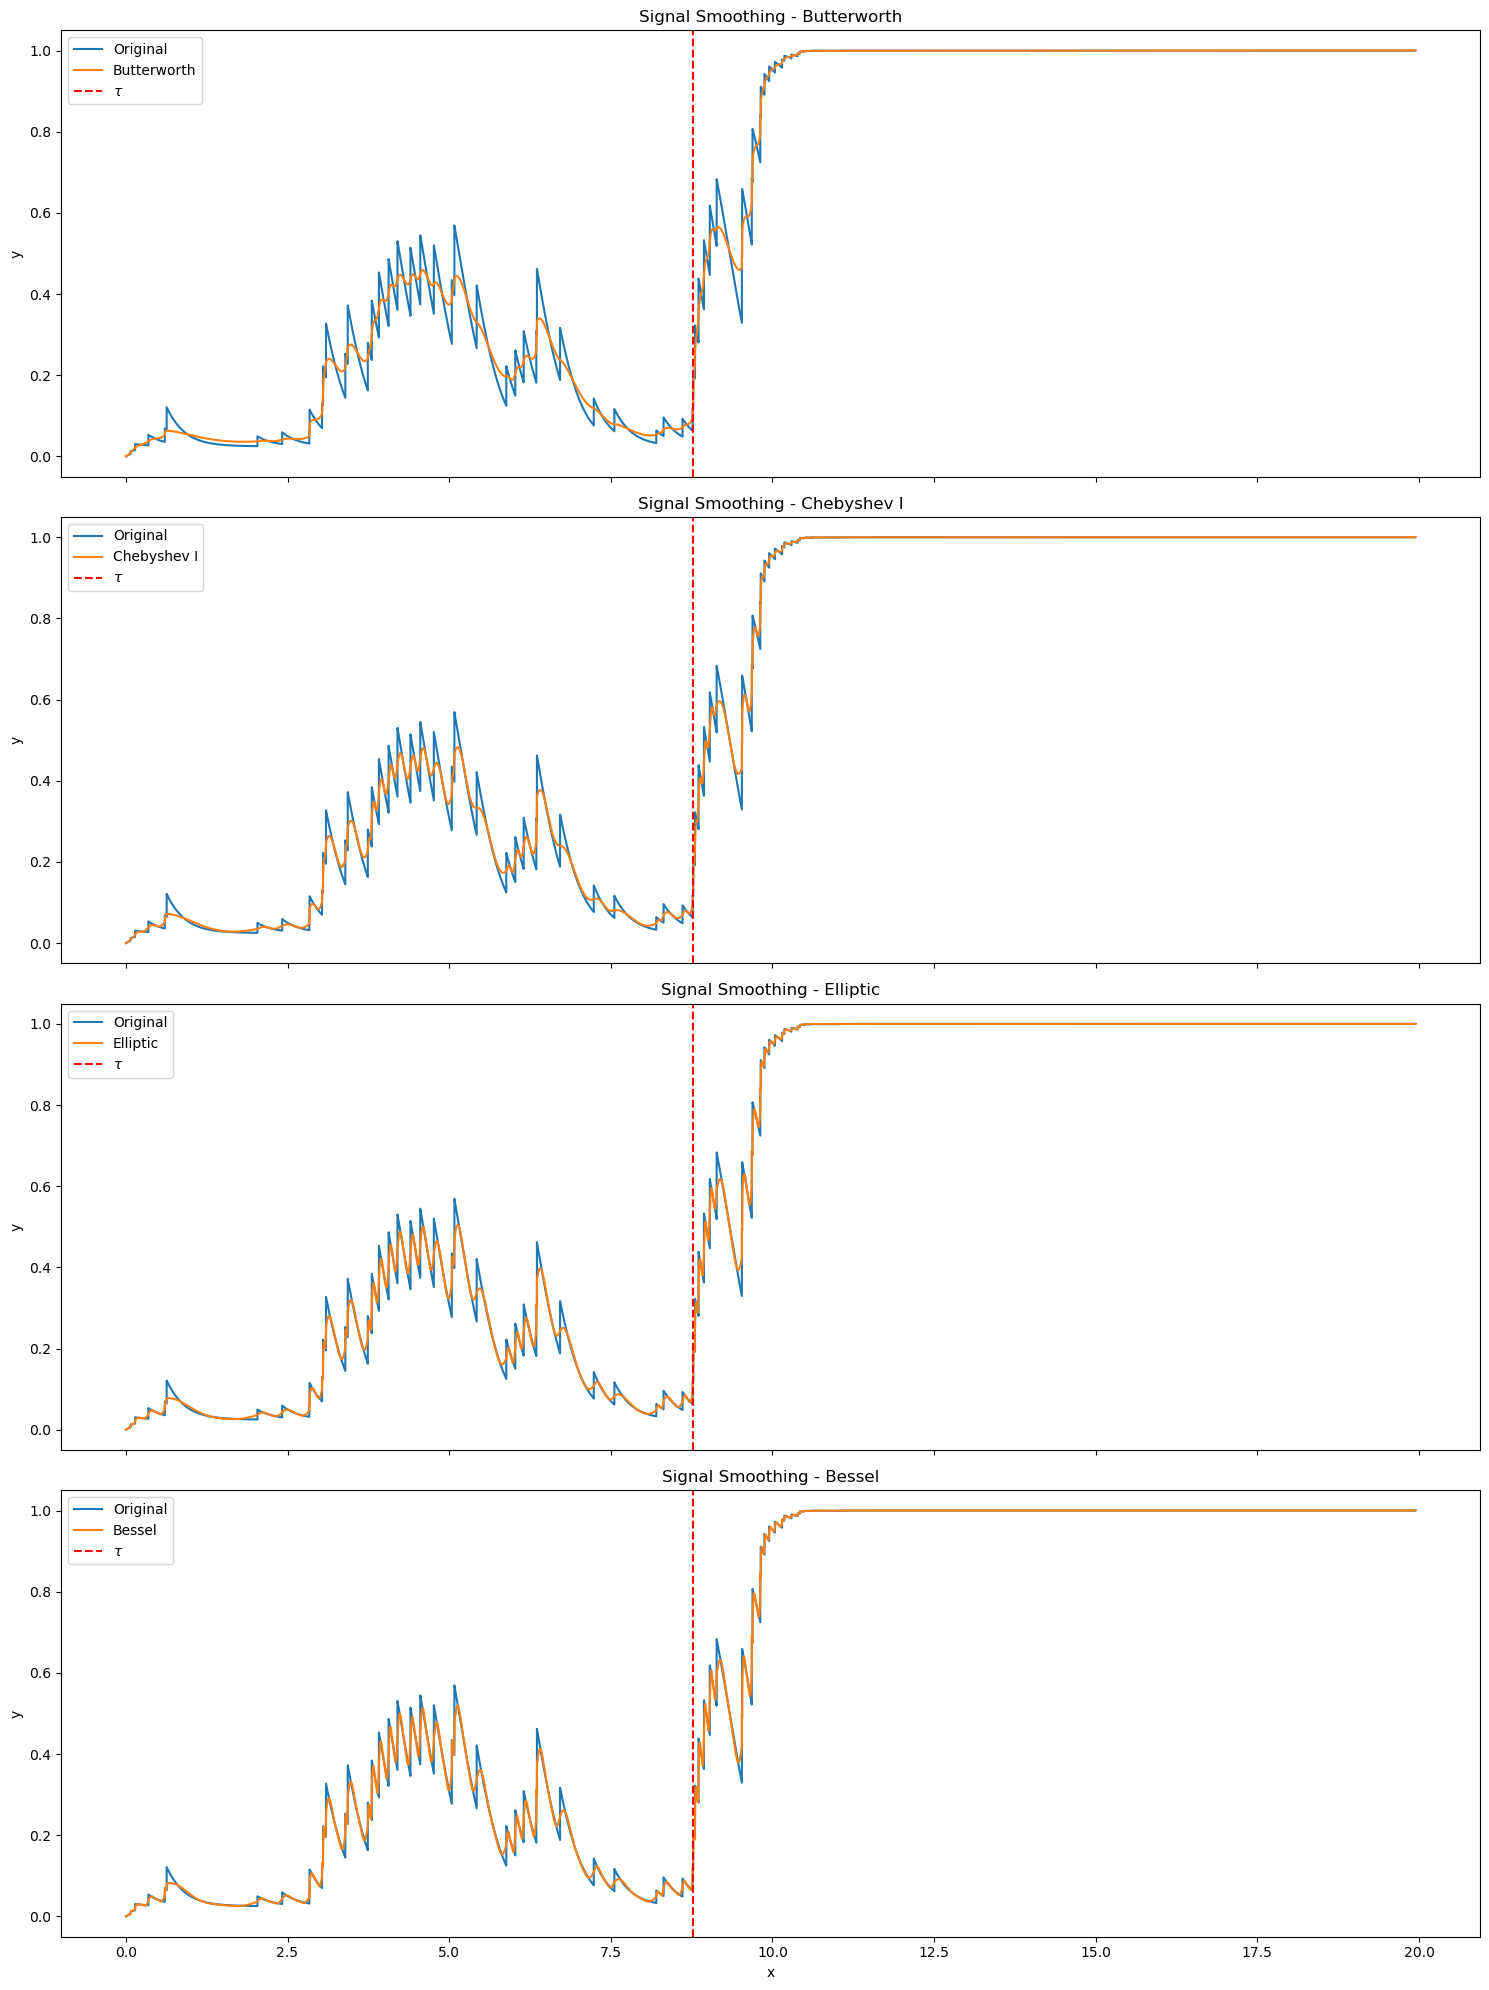

In [163]:
# Plot the smoothed signals

# Create subplots for each filter
num_filters = len(filters)
fig, axs = plt.subplots(num_filters, 1, figsize=(15, 5*num_filters), sharex=True)

# Apply filters and plot smoothed signals
for i, filter_params in enumerate(filters):
    
    # Apply filter
    b, a = signal.butter(filter_params['order'], filter_params['cutoff_freq'], analog=False)
    smoothed_z = signal.filtfilt(b, a, Z)

    # Plot original and smoothed signals for each filter
    axs[i].plot(t, Z, label='Original')
    axs[i].plot(t, smoothed_z, label=filter_params['name'])
    
    # Add vertical line at tau, to display clearly the change of behavior of the signal between t < tau and t > tau
    axs[i].axvline(x=tau, color='red', linestyle='--', label=r'$\tau$')
    
    axs[i].set_title('Signal Smoothing - {}'.format(filter_params['name']))
    axs[i].set_ylabel('y')
    axs[i].legend()

# Set x-axis label and the spacing between subplots
plt.xlabel('x')
plt.tight_layout()

# Show the figure
plt.show()


### **3.2 - Estimation of** $\tau$ **through the method of threshold crossing**

Before applying the method of threshold crossing, we need to determine the threshold $\theta$.

Thus, we simulate $N$ and $\hat{Z}$ many times and we determine experimentally which threshold suits best each filtering.

In [164]:
# Parameters to fix for the computation of an optimal threshold

inf = 0.25 # lower bound of the interval
sup = 0.75 # upper bound of the interval
n_thresholds = 50 # number of points in the interval
n_exp = 10 # number of experiments for each threshold
n_step = 2000 # number of steps for numerical integration


In [173]:
# Estimate tau through a threshold with the smoothed signal

def estimate_tau(t, threshold, smoothed_Z):
    """
    Estimates the value of tau based on a threshold and smoothed signal.

    Args:
        t (ndarray): Array of time values.
        threshold (float): Threshold value.
        smoothed_Z (ndarray): Array of smoothed signal values.

    Returns:
        tau (float or None): Estimated value of tau.
    """
    # Initialize an empty list to store indexes where the signal crosses the threshold
    indexes_cross_threshold = []
    
    # Iterate over the smoothed signal values
    for i in range(1, len(smoothed_Z)):
        # Check if the current value is above the threshold and the previous value is below or equal to the threshold
        if (smoothed_Z[i] > threshold and smoothed_Z[i-1] <= threshold):
            # If the condition is satisfied, add the index to the list
            indexes_cross_threshold.append(i)

    # If no indexes were found, return None
    if len(indexes_cross_threshold) == 0:
        return None
    
    # If only one index was found, return the corresponding time value
    if len(indexes_cross_threshold) > 0:
        return t[indexes_cross_threshold[-1]]
    
    # If multiple indexes were found, return the average of the time values corresponding to the last two indexes, meaning the last two times the signal crossed the threshold
    else:
        return (t[indexes_cross_threshold[-1]] + t[indexes_cross_threshold[-2]]) / 2

    

In [174]:
# Function to determine the optimal threshold

def error_threshold(n_experiences, n_step, num_thresholds, end, inf, sup, filters):
    """
    Function to determine the optimal threshold.

    Args:
        n_experiences (int): Number of experiences.
        n_step (int): Number of steps for numerical integration.
        num_thresholds (int): Number of thresholds to test.
        end (float): End value for the time interval.
        inf (float): Lower bound of the threshold range.
        sup (float): Upper bound of the threshold range.
        filters (list): List of filters.

    Returns:
        errors (ndarray): Array of errors for each filter and threshold combination.
        tested_thresholds (ndarray): Array of tested thresholds.

    """
    
    num_filters = len(filters)
    errors = np.zeros((num_filters, num_thresholds))
    tested_thresholds = np.linspace(inf, sup, num_thresholds)
    
    for j in range(num_thresholds):
        
        for _ in range(n_experiences):
            
            # Simulate the point process
            (tau_exact, points0_, points1_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)
            
            # Compute Z(t)
            Z_, t_ = compute_Z(points0=points0_, points1=points1_, sigma=sigma, lambda0=lambda0, lambda1=lambda1, n_step=n_step)
            
            for i, filt in enumerate(filters):
                # Apply filter
                order = filt['order']
                cutoff_freq = filt['cutoff_freq']
                b, a = signal.butter(order, cutoff_freq, analog=False)
                smoothed_Z = signal.filtfilt(b, a, Z_)
                
                # Compute the error between the estimated tau and the exact tau
                errors[i, j] += abs(estimate_tau(t_, tested_thresholds[j], smoothed_Z) - tau_exact)

    return errors , tested_thresholds

In [175]:
# Function to compute the errors and plot them against the thresholds

def plot_errors_thresholds(tested_thresholds, errors, filters):
    num_filters = len(filters)

	# Create subplots for each filter
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout(pad=3.0)

    for i in range(num_filters):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        filt = filters[i]
        filt_name = filt['name']
        
        # Plot errors against thresholds for the current filter
        ax.plot(tested_thresholds, errors[i], label=f"{filt_name}: Order {filt['order']}, Cutoff {filt['cutoff_freq']}")
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Error')
        ax.set_title(f'Errors vs Thresholds - {filt_name}')
        ax.legend()

    plt.show()




**Warning** : The next cell takes a long time to run.

In [176]:
# Effectively compute the errors

errors, tested_thresholds = error_threshold(n_exp, n_step, n_thresholds, end, inf, sup, filters)



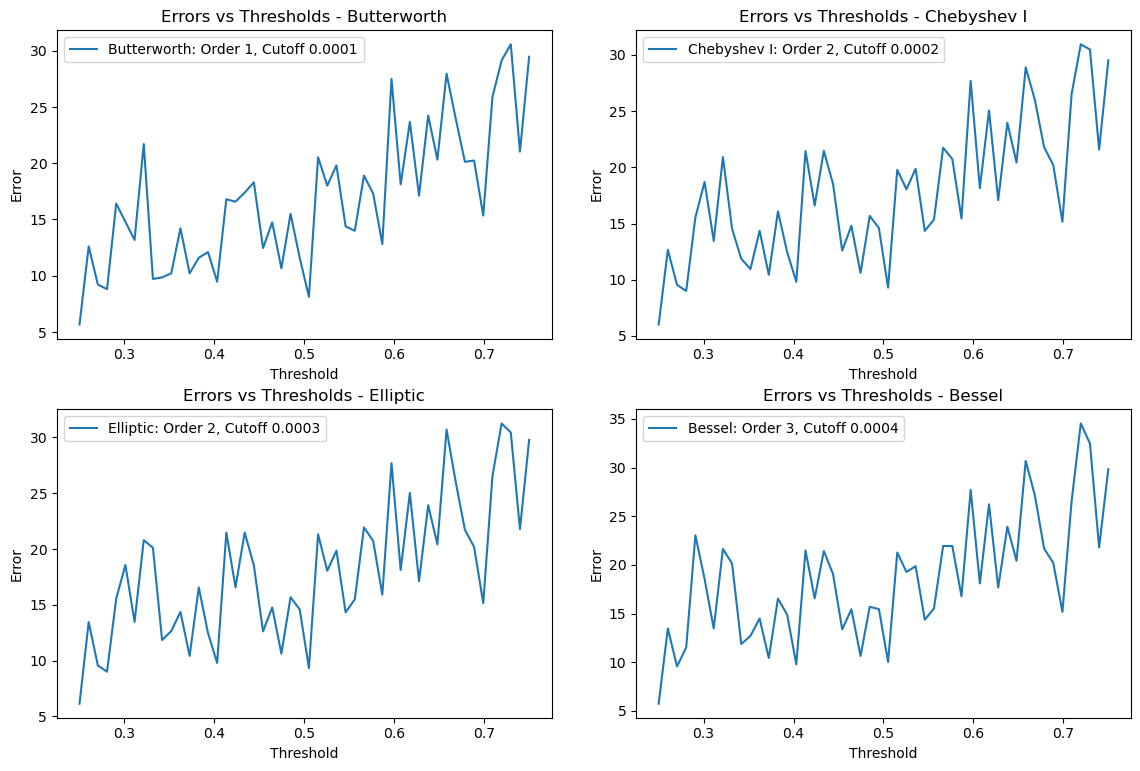

In [177]:
# Plot the errors against the thresholds for each filter

plot_errors_thresholds(tested_thresholds, errors, filters)

In [249]:
# Recover the optimal threshold for each filter

thres_butter = tested_thresholds[np.argmin(errors[0])]
thres_cheby = tested_thresholds[np.argmin(errors[1])]
thres_ellip = tested_thresholds[np.argmin(errors[2])]
thres_bessel = tested_thresholds[np.argmin(errors[3])]

print("The optimal threshold for the Butterworth filter is: ", thres_butter)
print("The optimal threshold for the Chebyshev I filter is: ", thres_cheby)
print("The optimal threshold for the Elliptic filter is: ", thres_ellip)
print("The optimal threshold for the Bessel filter is: ", thres_bessel)

The optimal threshold for the Butterworth filter is:  0.25
The optimal threshold for the Chebyshev I filter is:  0.25
The optimal threshold for the Elliptic filter is:  0.25
The optimal threshold for the Bessel filter is:  0.25


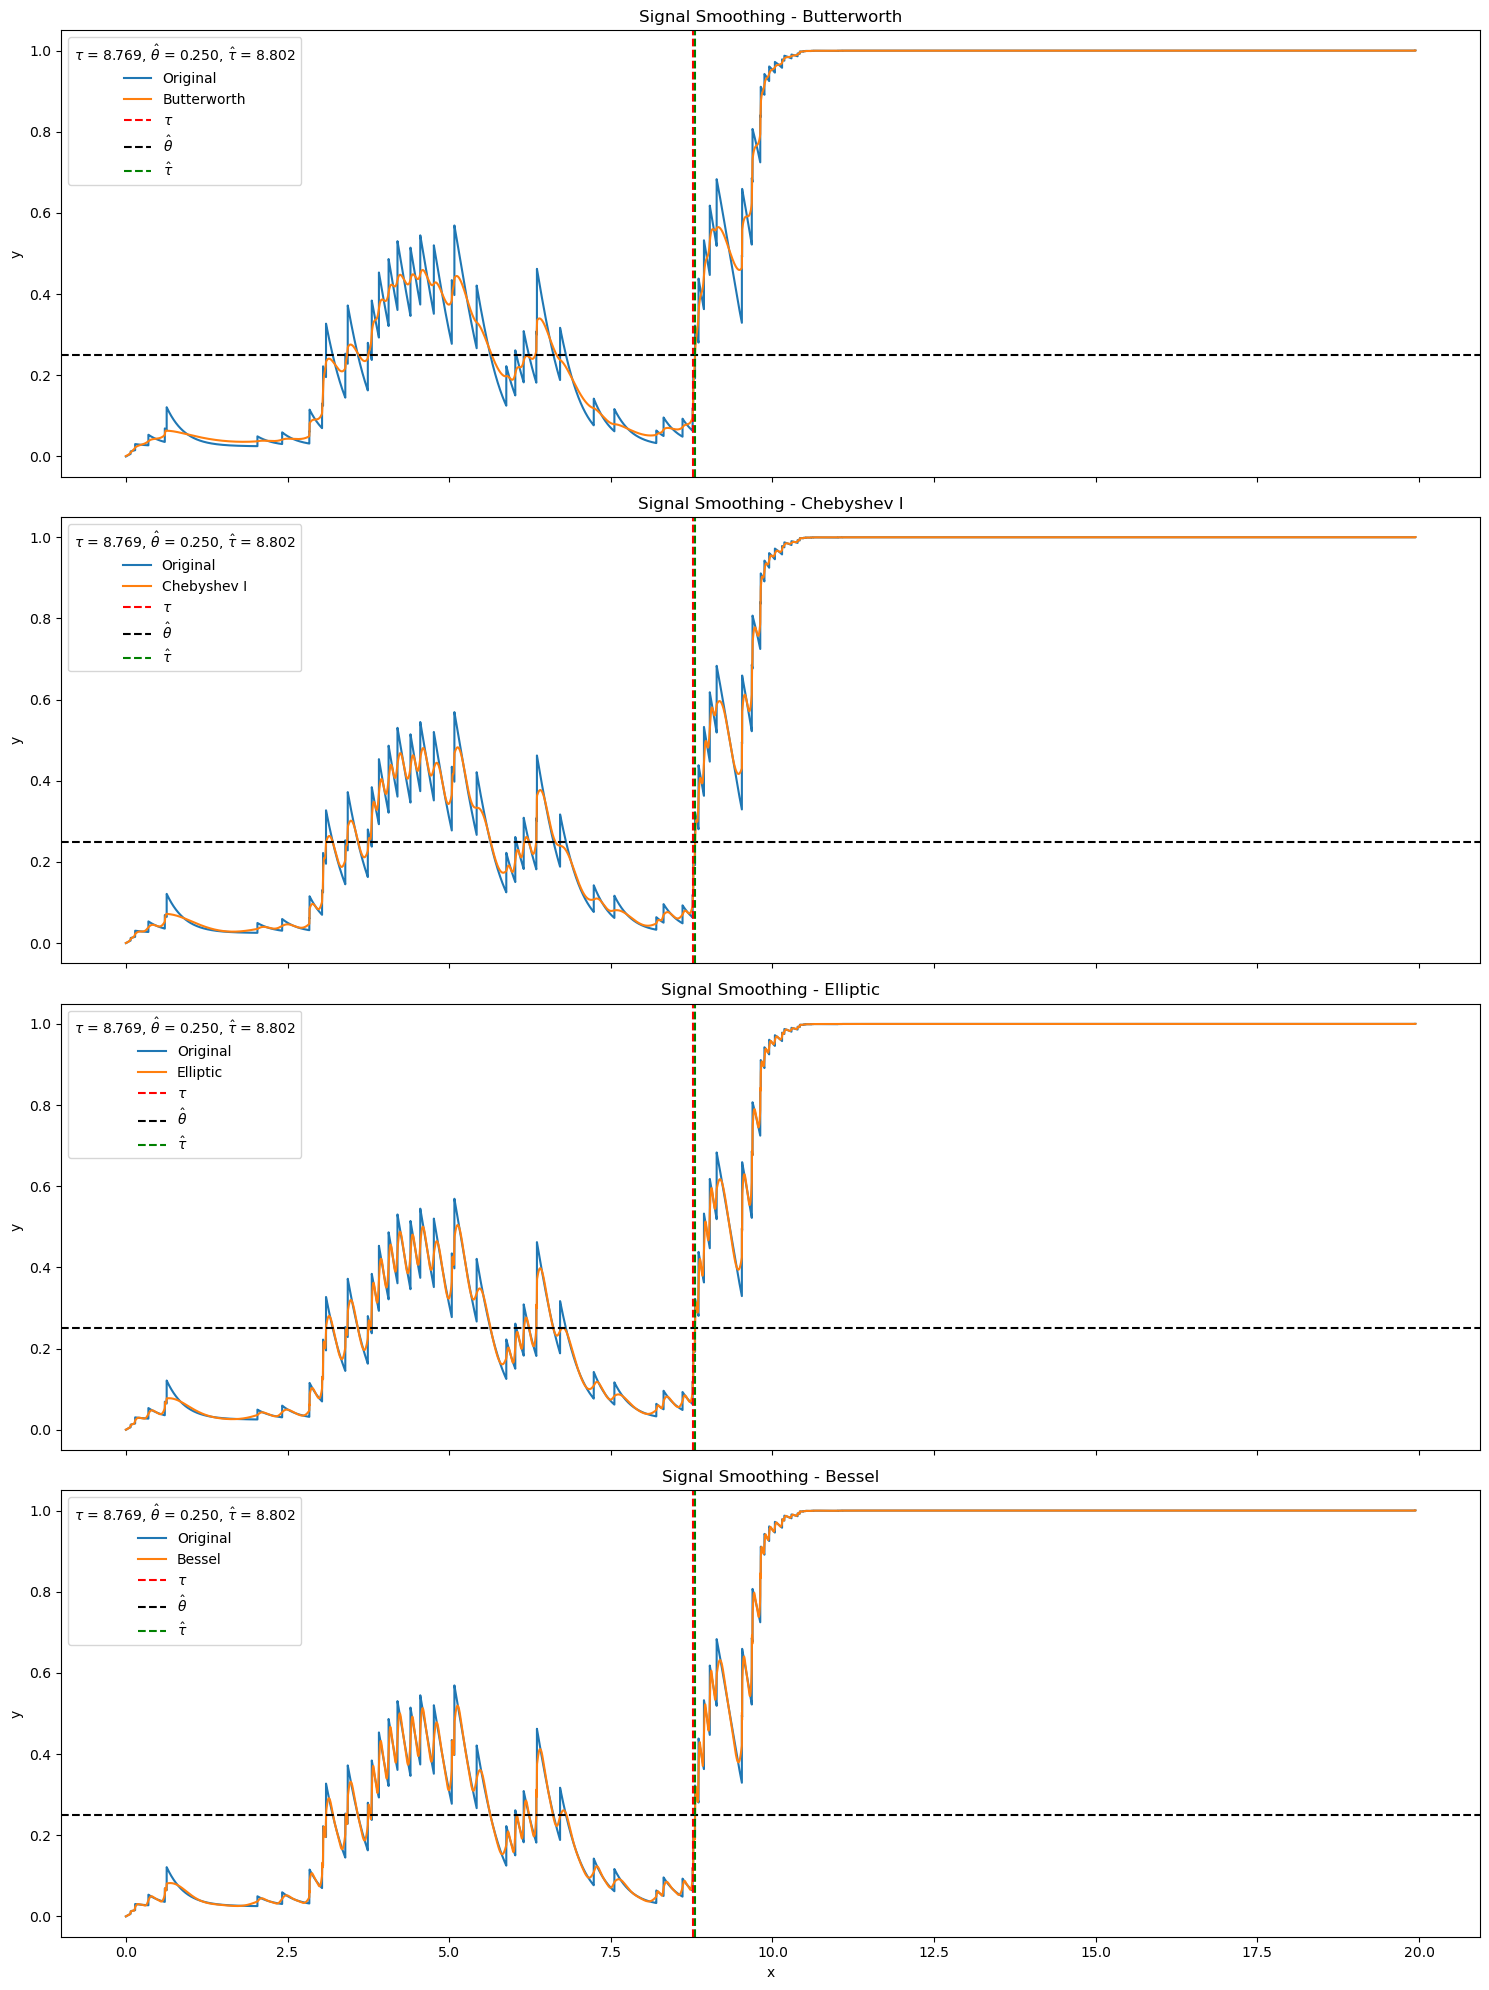

In [250]:
# Plot the smoothed signals with the optimal thresholds, tau, and tau_hat

# Create subplots for each filter
num_filters = len(filters)
fig, axs = plt.subplots(num_filters, 1, figsize=(15, 5*num_filters), sharex=True)

# Apply filters and plot smoothed signals
for i, filter_params in enumerate(filters):
    b, a = signal.butter(filter_params['order'], filter_params['cutoff_freq'], analog=False)
    smoothed_y = signal.filtfilt(b, a, Z)

    # Plot original and smoothed signals for each filter
    axs[i].plot(t, Z, label='Original')
    axs[i].plot(t, smoothed_y, label=filter_params['name'])
    axs[i].axvline(x=tau, color='red', linestyle='--', label=r'$\tau$')
    axs[i].axhline(y=tested_thresholds[np.argmin(errors[i])], color='black', linestyle='--', label=r'$\hat{\theta}$')
    tau_hat = estimate_tau(t, tested_thresholds[np.argmin(errors[i])], smoothed_y)
    axs[i].axvline(x=tau_hat, color='green', linestyle='--', label=r'$\hat{\tau}$')
    
    # Add legend with tau, theta_hat, and tau_hat values
    legend_text = r'$\tau$ = {:.3f}, $\hat{{\theta}}$ = {:.3f}, $\hat{{\tau}}$ = {:.3f}'.format(tau, tested_thresholds[np.argmin(errors[i])], tau_hat)
    axs[i].legend(title=legend_text)
    
    axs[i].set_title('Signal Smoothing - {}'.format(filter_params['name']))
    axs[i].set_ylabel('y')

# Set common x-axis label and adjust spacing
plt.xlabel('x')
plt.tight_layout()

# Show the figure
plt.show()


In this specific case, the thresholds are the same for each filter and we have a great accuracy. However, we will see down below that it is not always the case and this case is rather an exception to have such a low error.

### **3.3 - Estimation of** $\tau$ **through the method of derivative**

As we have seen in the introduction, $\tau = argmax_{t \geq 0} \mathbb{P}(\tau = t) = \argmax_{t \geq 0} Z'(t)$.

Thus, let's consider the following estimator of $\tau$:

$$\hat{\tau} = argmax_{t \geq 0} \hat{Z}'(t)$$

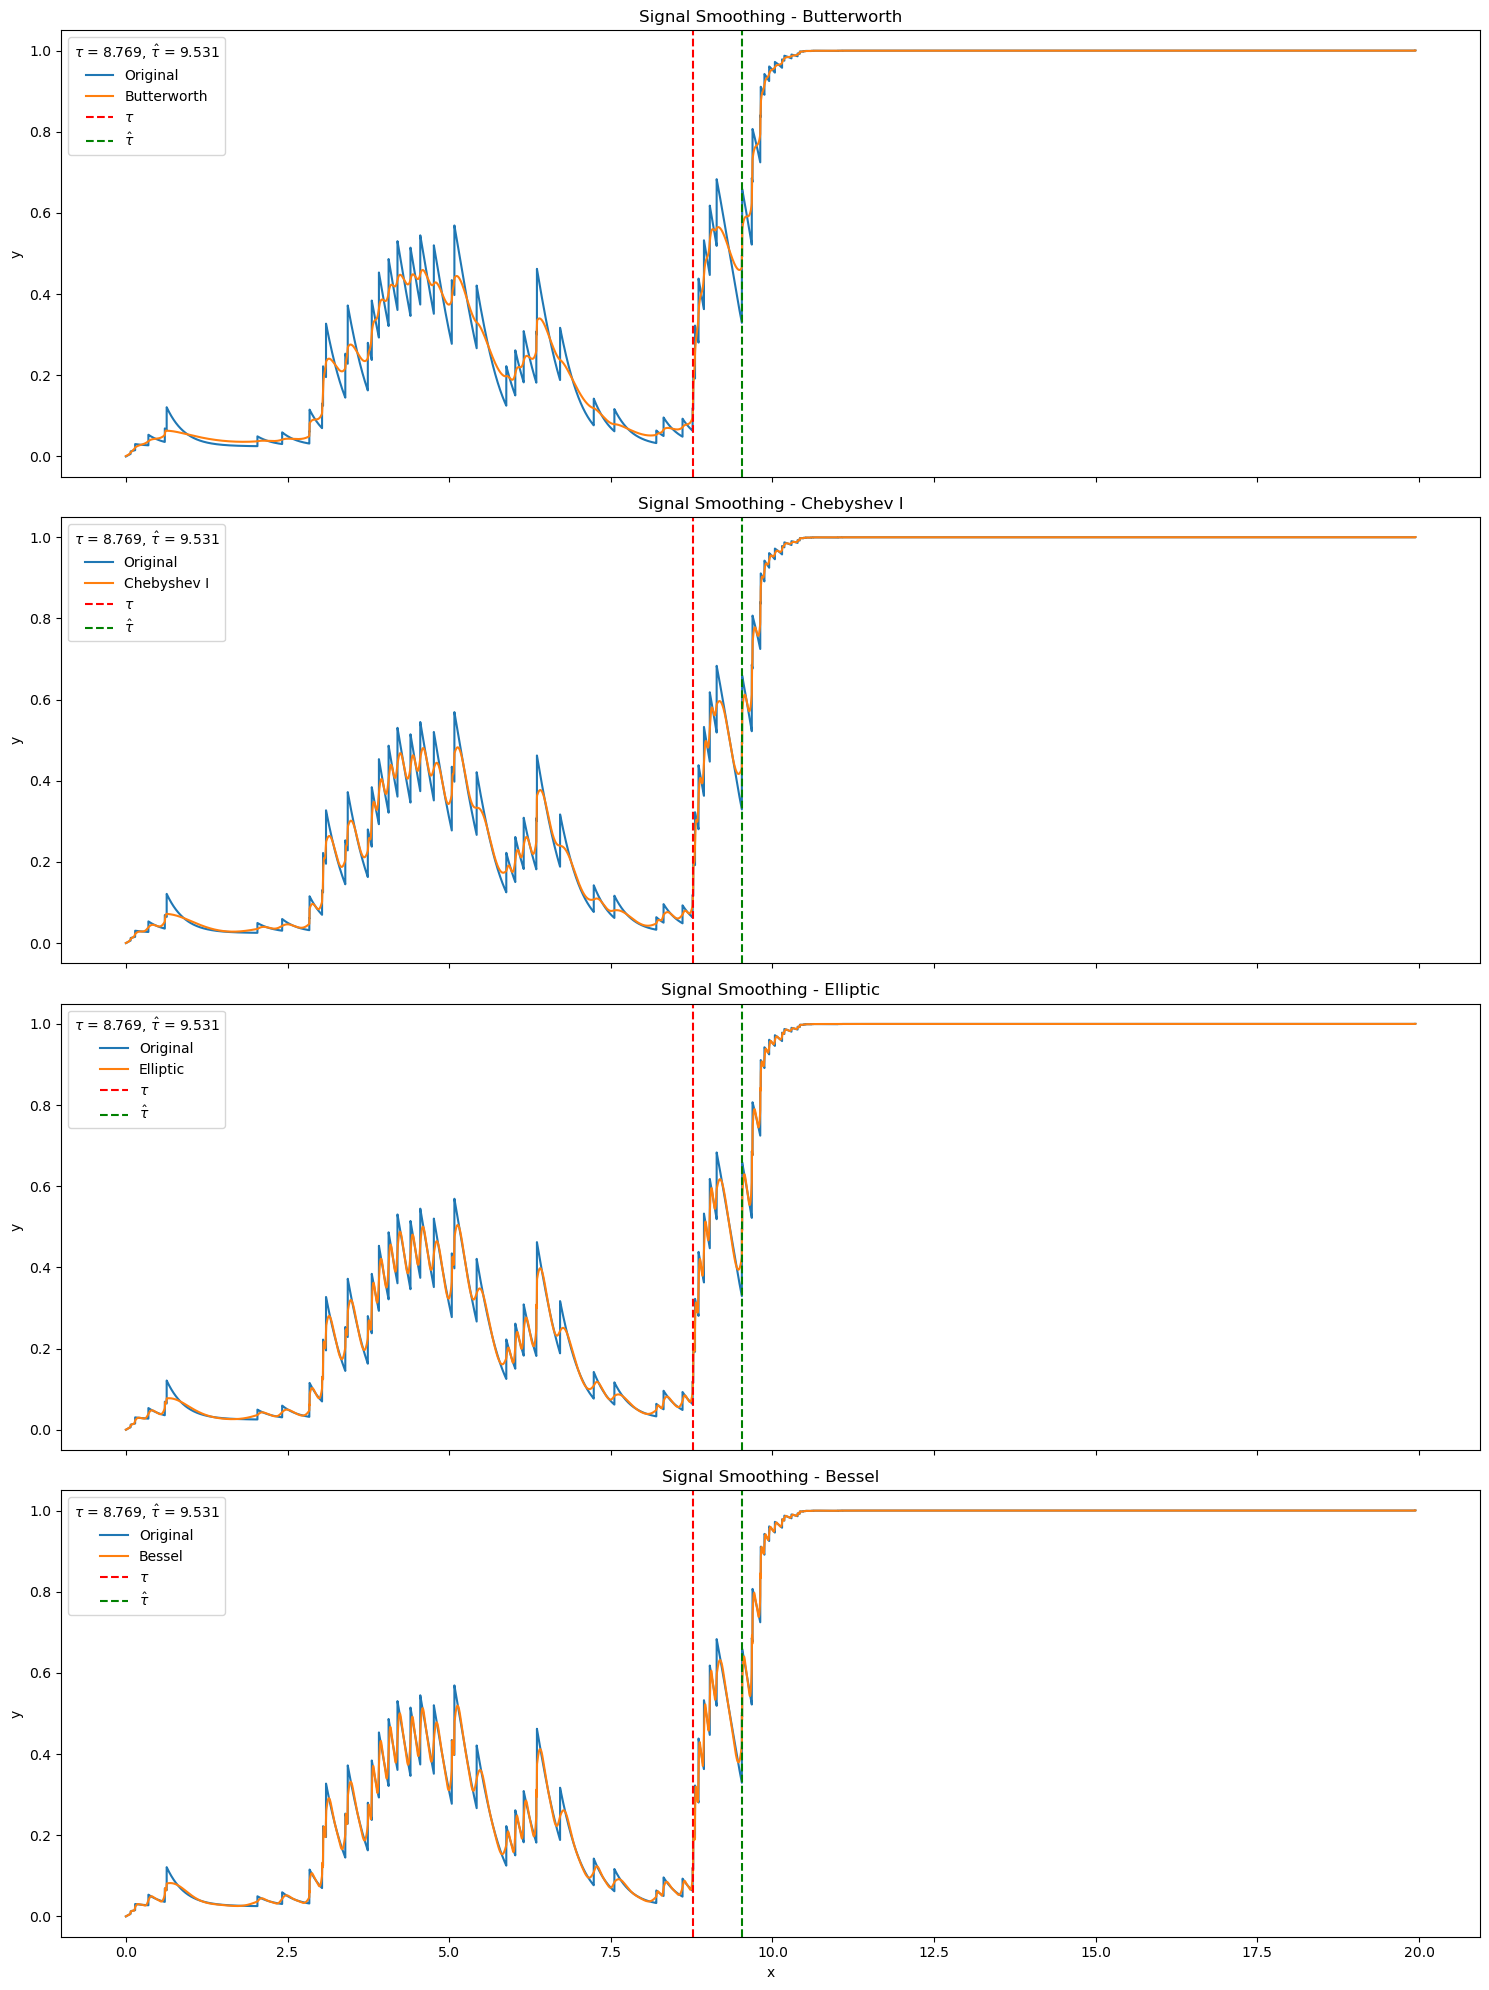

In [180]:
# Compute the argmax of the derivative of the smoothed signal and plot it as tau_hat

# Create subplots for each filter
num_filters = len(filters)
fig, axs = plt.subplots(num_filters, 1, figsize=(15, 5*num_filters), sharex=True)

# Apply filters and plot smoothed signals
for i, filter_params in enumerate(filters):
    # Apply filter
    b, a = signal.butter(filter_params['order'], filter_params['cutoff_freq'], analog=False)
    smoothed_y = signal.filtfilt(b, a, Z)
    
    # Estimate tau by detecting the maximum of the derivative of the smoothed signal
    tau_hat = t[np.argmax(np.gradient(smoothed_y))]

    # Plot original and smoothed signals for each filter
    axs[i].plot(t, Z, label='Original')
    axs[i].plot(t, smoothed_y, label=filter_params['name'])
    
    # Add vertical lines at tau and tau_hat
    axs[i].axvline(x=tau, color='red', linestyle='--', label=r'$\tau$')
    axs[i].axvline(x=tau_hat, color='green', linestyle='--', label=r'$\hat{\tau}$')
    
    # Add legend with tau and tau_hat values
    legend_text = r'$\tau$ = {:.3f}, $\hat{{\tau}}$ = {:.3f}'.format(tau, tau_hat)
    axs[i].legend(title=legend_text)
    
    axs[i].set_title('Signal Smoothing - {}'.format(filter_params['name']))
    axs[i].set_ylabel('y')

# Set common x-axis label and adjust spacing
plt.xlabel('x')
plt.tight_layout()

# Show the figure
plt.show()


We can see here that the estimation of $\tau$ is based on the derivative of $\hat{Z}(t)$ is not completely accurate. However, it still gives us a good approximation of $\tau$, and the gap with the threshold crossing method is bigger with this example than usual as we will see down below.

The issue with the derivative is that it is very sensitive on the jumps and even with the signal filtering, we still have big jumps meaning very high values of the derivative. Thus, the estimation of $\tau$ is not as accurate as we would like it to be.

## **Question 4 - Finding another estimator of** $\tau$

We want to find another estimator of $\tau$ that does not use the threshold $\theta$ and does not use the derivative of $\hat{Z}$.

Up until now, we have only focused on $Z$. Let's try to find something over the number of points $N$.

We have the tuple $(N_0(t), N_1(t))$ which represents the number of points before and after $\tau$. The tuple follows the following density against the counting measure:

for $n_0, n_1 \in \mathbb{N}$,

$$\mathbb{P}(N_0(t) = n_0, N_1(t) = n_1) = \frac{(\lambda_0 t)^{n_0} e^{-\lambda_0 t}}{n_0!} \frac{(\lambda_1 (t_{end}-t))^{n_1} e^{-\lambda_1 (t_{end}-t)}}{n_1!} = f(n_0,n_1;t)$$

Thus we can apply the technique of maximum likelihood to find an estimator of $\tau$ :

$$\hat{\tau} = \argmax_{t \in [0,t_{end}]} f(N_0(t), N_1(t);t)$$

Furthermore, we use the log-likelihood to simplify the calculations:

$$\hat{\tau} = \argmax_{t \in [0,t_{end}]} \log(f(N_0(t), N_1(t);t))$$

Hence, we several simulations of $N$, we can estimate $\tau$.

In [181]:
# Compute the log-likelihood function


def log_likelihood_func(tau, n0, n1, lambda0, lambda1, tend):
    """
    Compute the log-likelihood function given the observed counts and parameters.

    Parameters:
        tau (float): The value of tau.
        n0 (list): List of observed counts for N0.
        n1 (list): List of observed counts for N1.
        lambda0 (float): Parameter lambda0 (intensity of the first Poisson process).
        lambda1 (float): Parameter lambda1 (intensity of the second Poisson process).
        tend (float): The end time.

    Returns:
        float: The value of the log-likelihood function.
    """
    
    res = 0
    for i in range(len(n0)):
        
        # We compute the log of the factorials using the gammaln function to avoid overflows from the factorials
        res += gammaln(n0[i]+1) + gammaln(n1[i]+1)
        res += -lambda0 * tau - lambda1 * (tend - tau) + n0[i] * np.log(lambda0 * tau) + n1[i] * np.log(lambda1 * (tend - tau))
        
    return res


In [182]:
# Compute the maximum likelihood estimator for tau

def maximize_likelihood(lambda0, lambda1, tend, tau, n_observations):
    """
    Compute the maximum likelihood estimator for tau.

    Parameters:
        lambda0 (float): Parameter lambda0 (intensity of the first Poisson process).
        lambda1 (float): Parameter lambda1 (intensity of the second Poisson process).
        tend (float): The end time.
        tau (float): The known value of tau.
        n_observations (int): The number of observations.

    Returns:
        float: The maximum likelihood estimator for tau.
    """
    
    # Storage for the number of points for N0 and N1 for each observation
    n0 = []
    n1 = []
    
    # Perform the specified number of observations of the point process
    for _ in range(n_observations):
        # Simulate the point process and retrieve the arrival times of N0 and N1
        (_, points0, points1) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end, tau=tau)
        
        # Store the number of points for N0 and N1
        n0.append(len(points0)-1)
        n1.append(len(points1))
    
    # Compute the maximum likelihood estimator for tau using the -log-likelihood function and minimizing it
    log_likelihood_function = lambda tau: -log_likelihood_func(tau, n0, n1, lambda0, lambda1, tend)
    result = minimize_scalar(log_likelihood_function, bounds=(0, tend), method='bounded')
    
    return result.x

In [183]:
# Estimation of tau

tau_hat = maximize_likelihood(lambda0, lambda1, end, tau, 10000)

print("Maximum Likelihood Estimator for tau:", tau_hat)
print("True value of tau:", tau)

Maximum Likelihood Estimator for tau: 8.763108838069712
True value of tau: 8.768643718363013


## **Conclusion**

Judging over the few simulations and results we computed so far, the maximum likelihood estimator seems to be the best one followed by the threshold method and finally the derivativer one. But let's run more simulations to be sure and have true numbers to compare.

### **Evaluating the errors**

In [184]:
# Function to evaluate the error of the threshold method

def evaluate_error_threshold(n_tries, n_step, end, order, cutoff, threshold):
    """
    Evaluates the error for a given threshold and filter parameters.

    Args:
        n_tries (int): Number of tries to perform.
        n_step (int): Number of steps for numerical integration.
        end (float): End value of the time interval.
        order (int): Order of the filter.
        cutoff (float): Cutoff frequency of the filter.
        threshold (float): Threshold value.

    Returns:
        error (float): Average error over the tries.
    """
    
    # Initialize the error
    error = 0

    # Perform the specified number of tries
    for _ in range(n_tries):
        
        # Simulate the process and compute Z
        (tau_exact, points0_, points1_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)
        Z_, t_ = compute_Z(points0=points0_, points1=points1_, sigma=sigma, lambda0=lambda0, lambda1=lambda1, n_step=n_step)
        
        # Apply the filter to the smoothed signal
        b, a = signal.butter(order, cutoff, analog=False)
        smoothed_Z = signal.filtfilt(b, a, Z_)
        
        # Compute the error by comparing the estimated tau with the exact tau
        error += abs(estimate_tau(t_, threshold, smoothed_Z) - tau_exact)

    # Return the average error
    return error / n_tries


In [185]:
# Function to evaluate the error of the derivative method

def evaluate_error_derivative(n_tries, n_step, end, order, cutoff):
    """
    Evaluates the error using the derivative method for a given filter.

    Args:
        n_tries (int): Number of tries to perform
        n_step (int): Number of steps for numerical integration.
        end (float): End value of the time interval.
        order (int): Order of the filter.
        cutoff (float): Cutoff frequency of the filter.

    Returns:
        error (float): Average error over the tries.
    """
    
    # Initialize the error
    error = 0

    # Perform the specified number of tries
    for _ in range(n_tries):
        
        # Simulate the process and compute Z
        (tau_exact, points0_, points1_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)
        Z_, t_ = compute_Z(points0=points0_, points1=points1_, sigma=sigma, lambda0=lambda0, lambda1=lambda1, n_step=n_step)
        
        # Apply the filter to the smoothed signal
        b, a = signal.butter(order, cutoff, analog=False)
        smoothed_Z = signal.filtfilt(b, a, Z_)
        
        # Estimate tau using the derivative method
        tau_hat = t_[np.argmax(np.gradient(smoothed_Z))]
        
        # Compute the error by comparing the estimated tau with the exact tau
        error += abs(tau_hat - tau_exact)

    # Return the average error
    return error / n_tries


In [186]:
# Function to evaluate the error of the maximum likelihood estimator method

def evaluate_error_mle(n_tries, end, n_observations):
    """
    Evaluates the error using the maximum likelihood estimator method.

    Args:
        n_tries (int): Number of tries.
        end (float): End value.
        n_observations (int): Number of observations.

    Returns:
        error (float): Average error over the tries.
    """
    # Initialize the error
    error = 0

    # Perform the specified number of tries
    for _ in range(n_tries):
        
        # Simulate the process and obtain the exact tau
        (tau_exact, points0_, points1_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)
        
        # Estimate tau using the maximum likelihood estimator method
        tau_hat = maximize_likelihood(lambda0, lambda1, end, tau_exact, n_observations)
        
        # Compute the error by comparing the estimated tau with the exact tau
        error += abs(tau_hat - tau_exact)

    # Compute the average error over the tries
    return error / n_tries


In [187]:
%%timeit
print("Average error for the threshold method with Butterworth filter:", evaluate_error_threshold(20, 5000, end, 1, 0.0001, thres_butter))

Average error for the threshold method with Butterworth filter: 1.0782456701421834
Average error for the threshold method with Butterworth filter: 1.2783319097937613
Average error for the threshold method with Butterworth filter: 0.8291577838078086
Average error for the threshold method with Butterworth filter: 1.0583113622441238
Average error for the threshold method with Butterworth filter: 1.1868056834370466
Average error for the threshold method with Butterworth filter: 1.6322065146284461
Average error for the threshold method with Butterworth filter: 0.8517266528378883
Average error for the threshold method with Butterworth filter: 0.934122736845245
5.39 s ± 296 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [188]:
%%timeit
print("Average error for the threshold method with Chebyshev I filter:", evaluate_error_threshold(20, 5000, end, 2, 0.0002, thres_cheby))

Average error for the threshold method with Chebyshev I filter: 1.6815640972251948
Average error for the threshold method with Chebyshev I filter: 1.042164245374026
Average error for the threshold method with Chebyshev I filter: 1.5295995998288845
Average error for the threshold method with Chebyshev I filter: 1.512427625549682
Average error for the threshold method with Chebyshev I filter: 1.1819373986085875
Average error for the threshold method with Chebyshev I filter: 1.051195013138084
Average error for the threshold method with Chebyshev I filter: 0.9456249408721309
Average error for the threshold method with Chebyshev I filter: 1.1307561360544645
5.19 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [189]:
%%timeit
print("Average error for the threshold method with Elliptic filter:", evaluate_error_threshold(20, 5000, end, 2, 0.0003, thres_ellip))

Average error for the threshold method with Elliptic filter: 1.1601376557833143
Average error for the threshold method with Elliptic filter: 0.9347556806554251
Average error for the threshold method with Elliptic filter: 1.5137305048180116
Average error for the threshold method with Elliptic filter: 1.1900691764307563
Average error for the threshold method with Elliptic filter: 1.3487206378652856
Average error for the threshold method with Elliptic filter: 0.9856631503189742
Average error for the threshold method with Elliptic filter: 0.9674750814928117
Average error for the threshold method with Elliptic filter: 0.8308081449495358
5.14 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [190]:
%%timeit
print("Average error for the threshold method with Bessel filter:", evaluate_error_threshold(20, 5000, end, 3, 0.0004, thres_bessel))

Average error for the threshold method with Bessel filter: 1.324587191314783
Average error for the threshold method with Bessel filter: 1.1671066195319078
Average error for the threshold method with Bessel filter: 1.0940679622152518
Average error for the threshold method with Bessel filter: 1.3070226864223418
Average error for the threshold method with Bessel filter: 0.9253562006681255
Average error for the threshold method with Bessel filter: 2.2597413887747364
Average error for the threshold method with Bessel filter: 1.5266967418204183
Average error for the threshold method with Bessel filter: 1.1664333103879814
5.03 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [191]:
%%timeit
print("Average error for the derivative method with Butterworth filter:", evaluate_error_derivative(20, 5000, end, 1, 0.0001))

Average error for the derivative method with Butterworth filter: 1.4728826275109126
Average error for the derivative method with Butterworth filter: 1.4797083144030951
Average error for the derivative method with Butterworth filter: 1.2879700566901289
Average error for the derivative method with Butterworth filter: 1.0706201790498444
Average error for the derivative method with Butterworth filter: 1.882939383361188
Average error for the derivative method with Butterworth filter: 2.1663824079060916
Average error for the derivative method with Butterworth filter: 1.4315370118590018
Average error for the derivative method with Butterworth filter: 1.6777451382848974
3.77 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [192]:
%%timeit
print("Average error for the maximum likelihood estimator method:", evaluate_error_mle(20, end, 10000))

Average error for the maximum likelihood estimator method: 0.006931309024205828
Average error for the maximum likelihood estimator method: 0.005749548532616178
Average error for the maximum likelihood estimator method: 0.005587118807766406
Average error for the maximum likelihood estimator method: 0.005934344225727105
Average error for the maximum likelihood estimator method: 0.0055918626352179784
Average error for the maximum likelihood estimator method: 0.00531417578323041
Average error for the maximum likelihood estimator method: 0.005830115412864166
Average error for the maximum likelihood estimator method: 0.004855368470399654
17.4 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


All the filters have similar errors. As a result, we used only the Butterworth filter for the derivative method. The derivative method looks to be slightly worse than the threshold one (even though the gap is inferior to what we have seen in the single sample path from the beginning). However, it does not require any computation prior to the estimation on the contrary to the threshold crossing method. Furthermore, it is more efficient in terms of computation time even without considering the computation of the threshold.

It is confirmed that the maximum likelihood estimator is the best one. But, it is also the most demanding in terms of computing ressources, as it takes 5 times as much time as for the derivative method. 
Furthermore, it is very accurate also because it relies on several simulations of the known process whereas the two other methods are directly applied on a single simulation (apart from the computation of the best threshold for the threshold crossing method).

Let's try to use the other methods with several simulations of the process and see if the results are better.

### **Using several simulations**

In [195]:
# Function to evaluate the error of the threshold method for several simulations

def evaluate_error_threshold_several_simulations(n_tries, n_step, n_observations, end, order, cutoff, threshold):
    """
	Evaluates the error for a given threshold and filter parameters.

	Parameters:
		n_tries (int): Number of tries to perform.
		n_step (int): Number of steps for numerical integration.
		n_observations (int): Number of observations.
		end (float): End value of the time interval.
		order (int): Order of the filter.
		cutoff (float): Cutoff frequency of the filter.
		threshold (float): Threshold value.

	Returns:
		error (float): Average error over the tries.
	"""
	
	# Initialize the error
    error = 0
    
    # Perform the specified number of tries
    for _ in range(n_tries):
        
        # Simulate a process, that will be simulated n_observations times
        (tau_exact,_,_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)
        
        tmp_error = 0
        
        for _ in range(n_observations):
            
            # Simulation of the chosen process
            (_, points0_, points1_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end, tau=tau_exact)
            Z_, t_ = compute_Z(points0=points0_, points1=points1_, sigma=sigma, lambda0=lambda0, lambda1=lambda1, n_step=n_step)
            
            # Apply the filter to the smoothed signal
            b, a = signal.butter(order, cutoff, analog=False)
            smoothed_Z = signal.filtfilt(b, a, Z_)
            
            # Compute the error by comparing the estimated tau with the exact tau
            tmp_error += abs(estimate_tau(t_, threshold, smoothed_Z) - tau_exact)
           
        # Compute the average error over the n_observations
        error += tmp_error / n_observations
    
    # Return the average error over the number of different simulations   
    return error / n_tries

In [196]:
# Function to evaluate the error of the derivative method for several simulations

def evaluate_error_derivative_several_simulations(n_tries, n_step, n_observations, end, order, cutoff):
    """
    Evaluates the error using the derivative method for a given filter.

    Args:
        n_tries (int): Number of tries to perform
        n_step (int): Number of steps for numerical integration.
        end (float): End value of the time interval.
        order (int): Order of the filter.
        cutoff (float): Cutoff frequency of the filter.

    Returns:
        error (float): Average error over the tries.
    """
    
    # Initialize the error
    error = 0

    # Perform the specified number of tries
    for _ in range(n_tries):
        
        # Simulate a process, that will be simulated n_observations times
        (tau_exact, _, _) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end)
        
        tmp_error = 0
        
        for _ in range(n_observations):
            
            # Simulation of the chosen process
            (_, points0_, points1_) = simulate_N(lambda0=lambda0, lambda1=lambda1, sigma=sigma, end=end, tau=tau_exact)
            Z_, t_ = compute_Z(points0=points0_, points1=points1_, sigma=sigma, lambda0=lambda0, lambda1=lambda1, n_step=n_step)
            
            # Apply the filter to the smoothed signal
            b, a = signal.butter(order, cutoff, analog=False)
            smoothed_Z = signal.filtfilt(b, a, Z_)
            
            # Estimate tau using the derivative method
            tau_hat = t_[np.argmax(np.gradient(smoothed_Z))]
            
            # Compute the error by comparing the estimated tau with the exact tau
            tmp_error += abs(tau_hat - tau_exact)
        
        # Compute the average error over the n_observations
        error += tmp_error / n_observations

    # Return the average error over the number of different simulations
    return error / n_tries


**Warning**: the next two cells take a long time to run.

In [200]:
%%timeit
print("Average error for the threshold method with Butterworth filter:", evaluate_error_threshold_several_simulations(20, 5000, 10, end, 1, 0.0001, thres_butter))

Average error for the threshold method with Butterworth filter: 1.2188164248658775
Average error for the threshold method with Butterworth filter: 1.09419619077746
Average error for the threshold method with Butterworth filter: 1.1478487191681694
Average error for the threshold method with Butterworth filter: 1.073555368693529
Average error for the threshold method with Butterworth filter: 1.2557140343414486
Average error for the threshold method with Butterworth filter: 1.1962575618380373
Average error for the threshold method with Butterworth filter: 1.193454489344624
Average error for the threshold method with Butterworth filter: 1.256674260738952
50.3 s ± 1.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [201]:
%%timeit
print("Average error for the derivative method with Butterworth filter:", evaluate_error_derivative_several_simulations(20, 5000, 10, end, 1, 0.0001))

Average error for the derivative method with Butterworth filter: 1.5395625071737373
Average error for the derivative method with Butterworth filter: 1.5976442138110138
Average error for the derivative method with Butterworth filter: 1.7562248376357652
Average error for the derivative method with Butterworth filter: 1.422838705874013
Average error for the derivative method with Butterworth filter: 1.7010245346524608
Average error for the derivative method with Butterworth filter: 1.6514248778301934
Average error for the derivative method with Butterworth filter: 1.540244591806736
Average error for the derivative method with Butterworth filter: 1.441646458084985
34.3 s ± 805 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [202]:
%%timeit
print("Average error for the maximum likelihood estimator method:", evaluate_error_mle(20, end, 10))

Average error for the maximum likelihood estimator method: 0.18841145158003275
Average error for the maximum likelihood estimator method: 0.22517250717038886
Average error for the maximum likelihood estimator method: 0.1673736632047133
Average error for the maximum likelihood estimator method: 0.2091123761119952
Average error for the maximum likelihood estimator method: 0.2538427199136617
Average error for the maximum likelihood estimator method: 0.20064294886364314
Average error for the maximum likelihood estimator method: 0.17627030736575433
Average error for the maximum likelihood estimator method: 0.20760393641651742
Average error for the maximum likelihood estimator method: 0.15578619516965314
Average error for the maximum likelihood estimator method: 0.18805730873632334
Average error for the maximum likelihood estimator method: 0.15814106783959783
Average error for the maximum likelihood estimator method: 0.1911488023348557
Average error for the maximum likelihood estimator metho

Because of the high duration time for the threshold and derivative methods with several simulations, we limited to 10 simulations. We  can see that the threshold and derivative do not really improve but are way slower to compute. This lack of real improvement may be explained by several factors such as the low number of simulations, the threshold being not optimal for the threshold crossing method.

Still, even with 10 simulations, the maximum likelihood estimator remains the best one and is still very accurate (a lot more than the two others). Furthermore, it still has by quite a margin the best accuracy and the computation time is now way less than the previous methods.

### **Optimizing the number of simulations**

Since we have succesfully determined that the maximum likelihood estimator is the best one when we have different simulations of the process.

To finish with, we can thus try to determine the best combinations of number of simulations for the maximum likelihood estimator method. Indeed, the purpose is to find a good trade-off between the amount of info necessary and the computation time.

In [216]:
# Parameters for the plot

n_tries = 10  # Fixed number of tries to make sure that error is not due to randomness
n_observations_values = np.linspace(10, 10000, 100, dtype=int)  # Range of n_observations values

**Warning**: the next cell takes a long time to run.

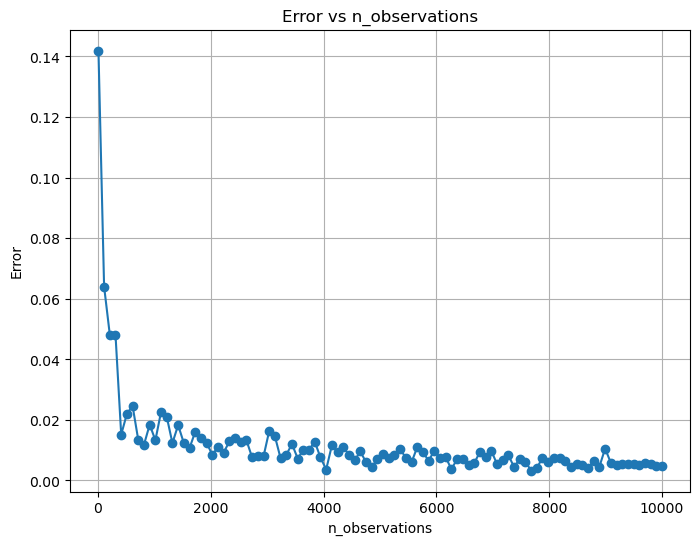

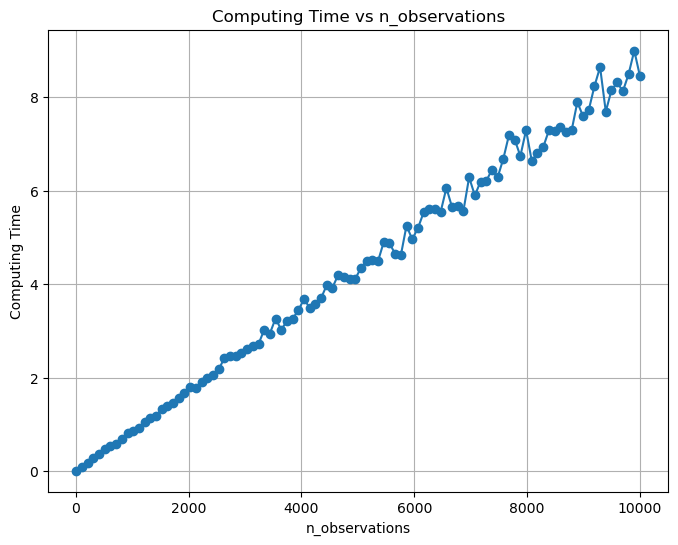

In [217]:
# Plot error vs n_observations, and computing time vs n_observations

# Initialize arrays to store results
errors = np.zeros((len(n_observations_values)))
computing_times = np.zeros((len(n_observations_values)))

# Perform the evaluation for different n_observations values
for i, n_observations in enumerate(n_observations_values):
    start_time = time.time()
    
    # Evaluate the error
    errors[i] = evaluate_error_mle(n_tries, end, n_observations)  # Using 1 try at a time
    
    # Calculate the computing time
    computing_times[i] = time.time() - start_time

# Plot error vs n_observations
plt.figure(figsize=(8, 6))
plt.plot(n_observations_values, errors, marker='o')
plt.xlabel('n_observations')
plt.ylabel('Error')
plt.title('Error vs n_observations')
plt.grid(True)
plt.show()

# Plot computation time vs n_observations
plt.figure(figsize=(8, 6))
plt.plot(n_observations_values, computing_times, marker='o')
plt.xlabel('n_observations')
plt.ylabel('Computing Time')
plt.title('Computing Time vs n_observations')
plt.grid(True)
plt.show()


We can see that the best combination looks to be around 1000 simultions to have a great accuracy and reasonable computation time. Over 1000 simulations, the accuracy does not improve a lot but the computation time continues to increase at the same rate.

To finish with, even though it is not in the spirit of the maximum likelihood, we would like to try over a single simulation. Indeed, at the beginning of the project we started with a single sample path. So we would like to see if the maximum likelihood estimator is still a good estimator over a single sample path. In this case, the other methods would be almost useless because in every case, the maximum likelihood estimator is the best one.

In [248]:
%%timeit
print("Average error for the maximum likelihood estimator method over a single simulation:", evaluate_error_mle(20, end, 1))

Average error for the maximum likelihood estimator method over a single simulation: 0.48193868811727436
Average error for the maximum likelihood estimator method over a single simulation: 0.7116396700731432
Average error for the maximum likelihood estimator method over a single simulation: 0.4937015927792229
Average error for the maximum likelihood estimator method over a single simulation: 0.596705063128504
Average error for the maximum likelihood estimator method over a single simulation: 0.6615464209146964
Average error for the maximum likelihood estimator method over a single simulation: 0.5945234161624493
Average error for the maximum likelihood estimator method over a single simulation: 0.4492312950914383
Average error for the maximum likelihood estimator method over a single simulation: 0.7127497094454937
Average error for the maximum likelihood estimator method over a single simulation: 0.4628367045160343
Average error for the maximum likelihood estimator method over a single s

We can see that the accuracy remains better than the other methods even though we have only one sample ! This is a great result because it means that the maximum likelihood estimator is very robust and it is not necessary to focus on Z to estimate $\tau$ with a single sample. We can just focus on the number of points before and after $\tau$.

### **Summary**

To sum up, we can say that over the methods of estimation of $\tau$ through $\hat{Z}$, we have found out that the best one is the threshold method applied to a filtered version of $\hat{Z}$.  However, this method relies on the fact that we have the possibility to numerically compute an optimal threshold. If we do not have this possibility, the derivative method is the best one. Indeed, it is applied directly to the filtered version of $\hat{Z}$ and does not require any computation prior to the estimation. Furthermore, it is more efficient in terms of computation time even without considering the computation of the threshold.

Still, those two methods remain quite highly unaccurate compared to the one we came up with in the last question.

Indeed, we tried focusing on other results and parameters from this problem and mainly on $N_1$ and $N_0$. And applying the maximum likelihood estimator on those parameters gave us a very accurate estimator of $\tau$. Furthermore, it does not require any computation prior to the estimation and is very efficient in terms of computation time. And, to compare it on the same basis as the two other methods, we applied it on a single sample path and it still gave us a better estimator of $\tau$.

Finally, we can then say that the maximum likelihood estimator is the one we recommend the most to estimate $\tau$ even though the other methods we tested can still work to estimate $\tau$.